In [1]:
using DataFrames, FileIO, DelimitedFiles
using Plots, Optim, LsqFit

In [2]:
function read_pop_file(filename, resnames)
    deprotonated_fraction =  Array{Float64, 1}(undef, length(resnames))
    pop_file = readdlm(filename, header = true)[1][2:end, 2:end]

    k = 0
    for resname in resnames
        k+=1
        if resname == "GL4"
            deprotonated_fraction[k] = pop_file[k, 3:end][1]
        elseif resname == "AS4"
            deprotonated_fraction[k] = pop_file[k, 3:end][1]
        elseif resname == "HIP"
            deprotonated_fraction[k] = 1 - pop_file[k, 3:end][1]
        elseif resname == "LYS"
            deprotonated_fraction[k] = 1 - pop_file[k, 3:end][1]
        elseif resname == "CYX"
            deprotonated_fraction[k] = 1 - pop_file[k, 3:end][1]
        elseif resname == "TYR"
            deprotonated_fraction[k] = 1 - pop_file[k, 3:end][1]
        end
    end
    
    return deprotonated_fraction
end

read_pop_file (generic function with 1 method)

In [3]:
# Get ready
home = "/home/pbarletta/labo/20/cph_obp/"
ctv_cph_out = string(home, "run/ctv/pdt/cph_outputs/")
ctv_cph_pre_out = string(home, "run/ctv/pre_pdt/cph_outputs/")

phs = collect(30:5:75)
pdt_steps = collect(0:1:7)
suffix_pka_file = "_pka"
suffix_pop_file = "_pop"
titrable_cnt = 36
titrable_resis = [4, 5, 7, 11, 13, 18, 20, 24, 27, 30, 33, 37, 39,
    40, 41, 42, 48, 52, 58, 59, 64, 69, 73, 77, 78, 82, 87, 93, 94,
    97, 99, 102, 109, 111, 114, 117];
titrable_resnames = ["GL4", "GL4", "LYS", "HIP", "GL4", "LYS", "GL4", "AS4", "LYS",
    "AS4", "GL4", "AS4", "GL4", "AS4", "LYS", "LYS", "GL4", "LYS",
    "AS4", "LYS", "LYS", "LYS", "GL4", "AS4", "GL4", "LYS", "AS4",
    "GL4", "GL4", "HIP", "LYS", "LYS", "LYS", "LYS", "LYS", "AS4"]
global const def_pka_as4 = 3.71
global const def_pka_gl4 = 4.15
global const def_pka_lys = 10.67
global const def_pka_hip = 6.04;
# global const def_pka_cyx = 8.14;
# global const def_pka_tyr = 10.1;

In [4]:
def_res_pka = Array{Float64, 1}(undef, titrable_cnt)

for i in 1:titrable_cnt
    if titrable_resnames[i] == "AS4"
        def_res_pka[i] = def_pka_as4
    elseif titrable_resnames[i] == "GL4"
        def_res_pka[i] = def_pka_gl4
    elseif titrable_resnames[i] == "LYS"
        def_res_pka[i] = def_pka_lys
    elseif titrable_resnames[i] == "HIP"
        def_res_pka[i] = def_pka_hip
    end
end

## Leo los \_pop files de todas las corridas

In [5]:
# Obtengo las poblaciones deprotonadas de c/ residuo a c/ valor de pH
# Leo el State 0 de c/ residuo. P/ lods residuos ácidos (GL4, AS4)
# el state 0 es deprotonado, p/ los básicos es protonado.
# Usaré estas poblaciones p/ ajustar la curva de Hill y obtener el valor de pKa.
deprotonated_fraction =  Array{Float64, 2}(undef, titrable_cnt, length(phs))
for i in 1:length(phs)
    
    pop_filename = joinpath(ctv_cph_out, "p", string(phs[i], suffix_pop_file))
    deprotonated_fraction[:, i] = read_pop_file(pop_filename, titrable_resnames)
end

## Leo los \_pka files, sólo de pre_pdt

In [6]:
# P/ ajustar bien la curva de Hill y obtener los parámetros n y pKa conviene
# empezar con unos buenos parámetros iniciales. P/ n eso es 1.0 y p/ pKa será
# el valor de pKa predicho durante la corrida con menor Offset. Por eso leo
# estos archivos de _pka, p/ obtener los pka predichos y sólo usar el q venga
# con de la corrida con menor offset. Cualquier cosa: ver papers de Swails.

res_offset_all = Array{Float64, 2}(undef, titrable_cnt, length(phs))
res_pka_pred_all = Array{Float64, 2}(undef, titrable_cnt, length(phs))
res_pka_pred =  Array{Float64, 1}(undef, titrable_cnt)

for i = 1:length(phs)
    pka_filename = joinpath(ctv_cph_out, "p", string(phs[i], suffix_pka_file))
    pka_file = readdlm(pka_filename, header = true)[1][1:end-1, 1:end-1]    
    res_offset_all[:, i] = pka_file[:, 5]
    res_pka_pred_all[:, i] = pka_file[:, 7]
end

for i = 1:titrable_cnt
    min_offset_idx = findmin(abs.(res_offset_all[i, :]))[2]
    res_pka_pred[i] = res_pka_pred_all[i, min_offset_idx]
end

## Determino Hill coefficients and pKas

In [7]:
# Hill coefficient and pKa for each residue 
res_pka =  Array{Float64, 1}(undef, titrable_cnt)
res_hil =  Array{Float64, 1}(undef, titrable_cnt)

# Hill function
@. f(x, hill_coef) = 1 / (1 + 10 ^(hill_coef[1]*(hill_coef[2] - x)) )
xdata = phs ./ 10

# Fit the curves
for i = 1:titrable_cnt
    hill_coef = [1. ; res_pka_pred[i]]
    fit = curve_fit(f, xdata, deprotonated_fraction[i, :], hill_coef)    
    res_hil[i] = fit.param[1]
    res_pka[i] = fit.param[2]
end

# Guardo los pkas obtenidos
writedlm(joinpath(home, "rtdos_log", "pka_ctv"), [titrable_resnames titrable_resis res_pka res_hil])

## Diferencias entre pka calculado y default

In [8]:
not_lys = titrable_resnames .!= "LYS"
etiquetas = string.(titrable_resnames[not_lys], " ", titrable_resis[not_lys])
dif_res_pka = map(-, res_pka, def_res_pka);

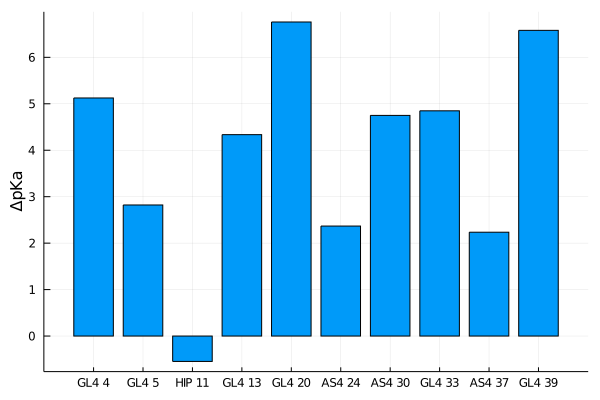

In [9]:
bar(etiquetas[1:10], dif_res_pka[not_lys][1:10], label = :none,
    ylabel = "ΔpKa")

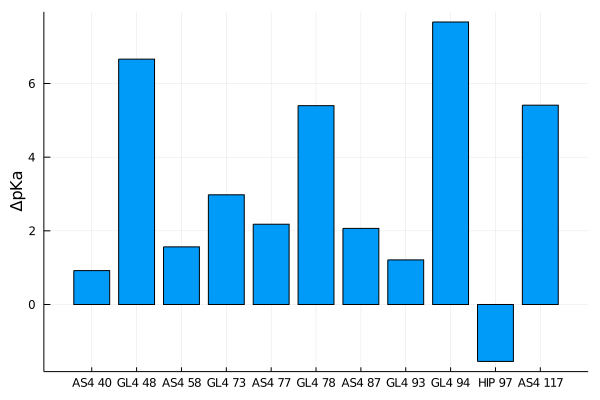

In [10]:
bar(etiquetas[11:end], dif_res_pka[not_lys][11:end], label = :none,
    ylabel = "ΔpKa")

### Plotteo

In [11]:
function titration_curve(n, pKa, x)
    return (1 / (1 + 10 ^(n*(pKa - x))))
end
x = collect(1:.1:14);

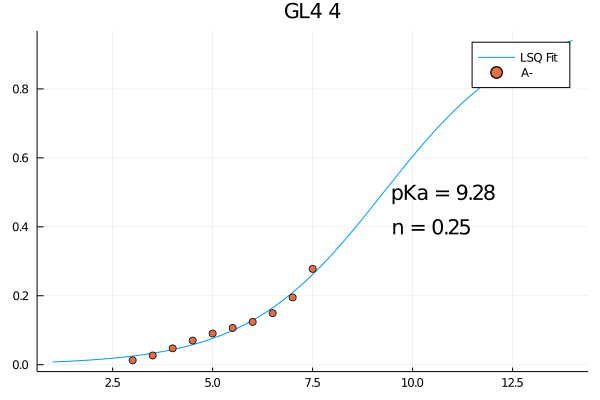

In [12]:
i = 1
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

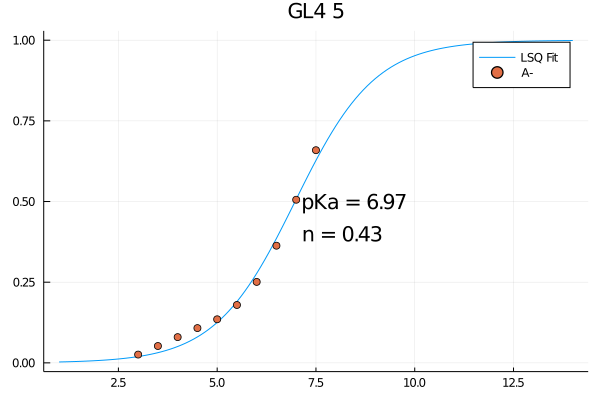

In [13]:
i = 2
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

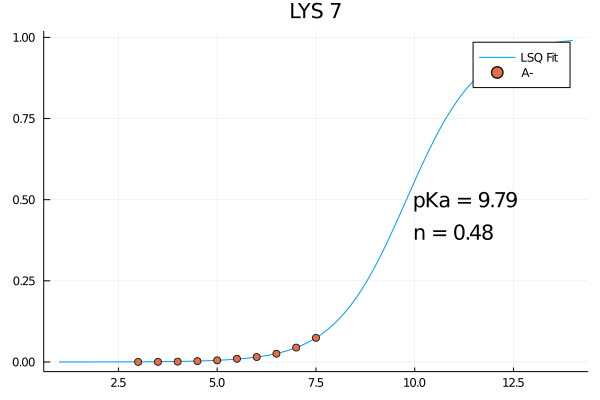

In [14]:
i = 3
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

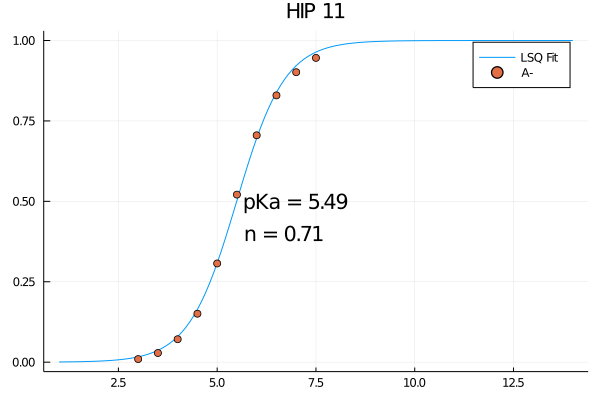

In [15]:
i = 4
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

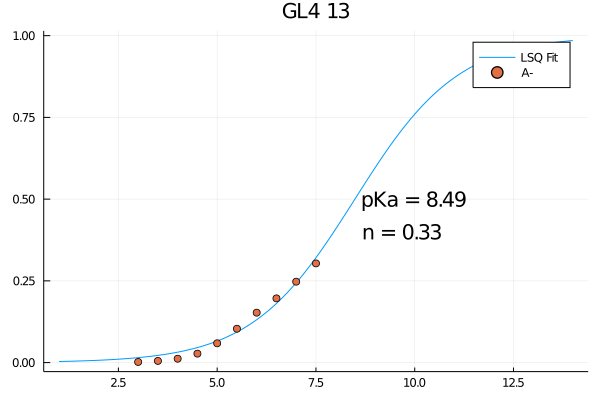

In [16]:
i = 5
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

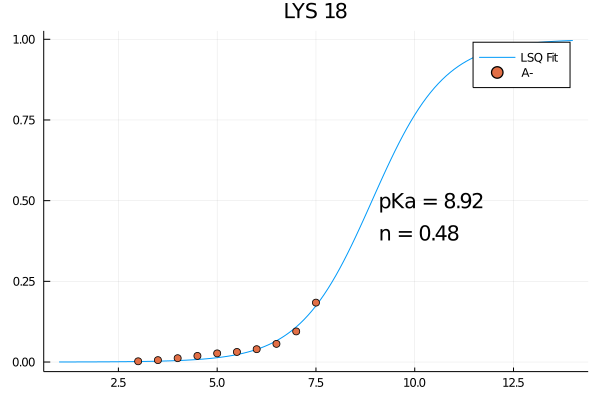

In [17]:
i = 6
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

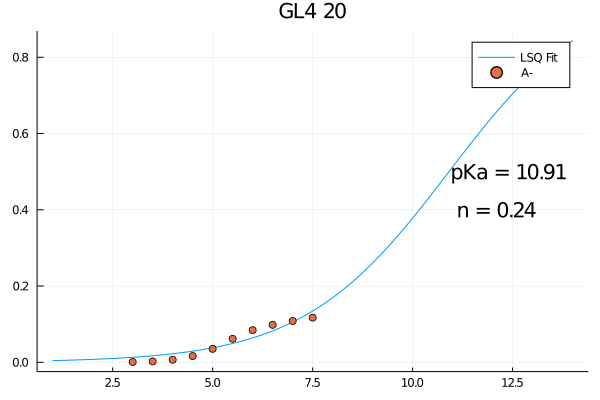

In [18]:
i = 7
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

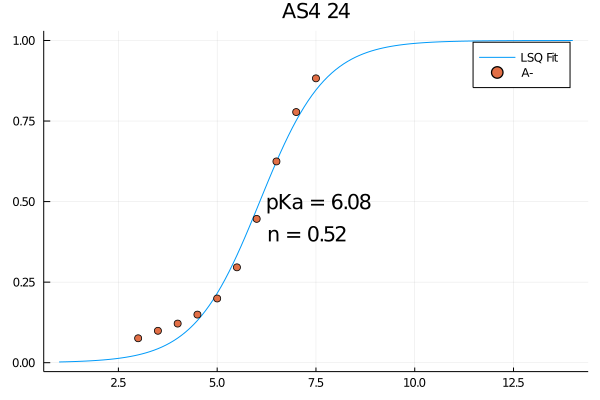

In [19]:
i = 8
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

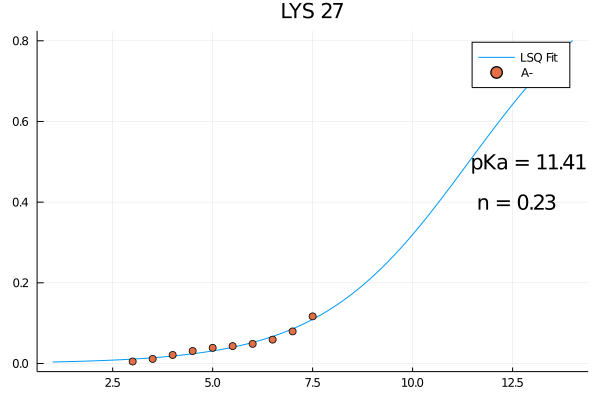

In [20]:
i = 9
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

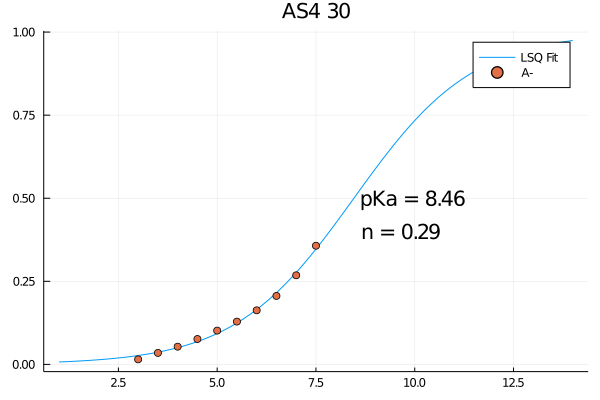

In [21]:
i = 10
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

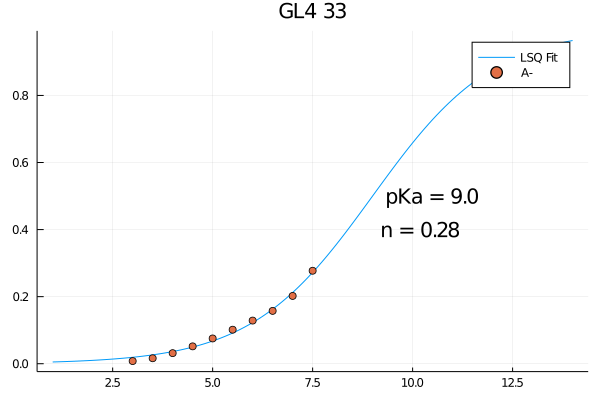

In [22]:
i = 11
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

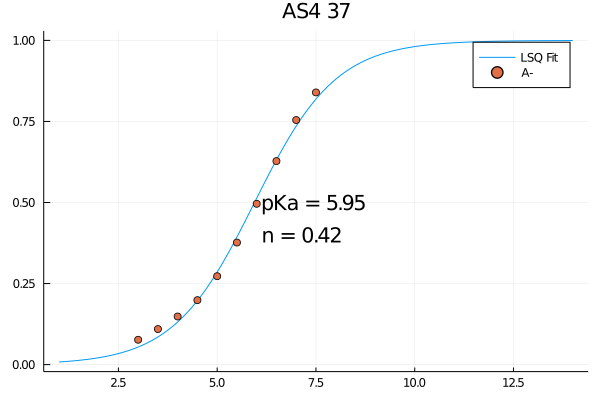

In [23]:
i = 12
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

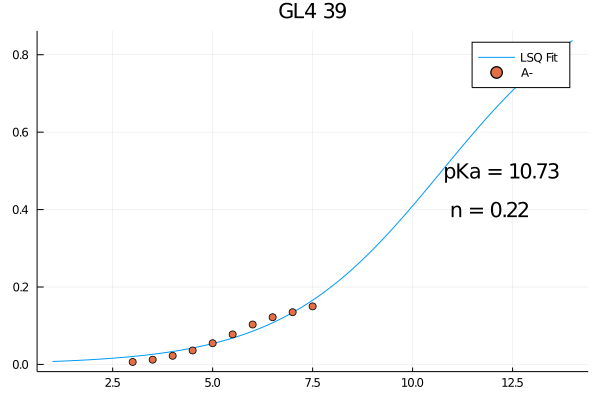

In [24]:
i = 13
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

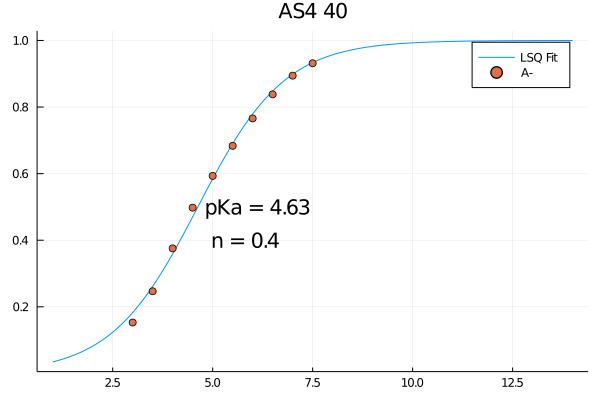

In [25]:
i = 14
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

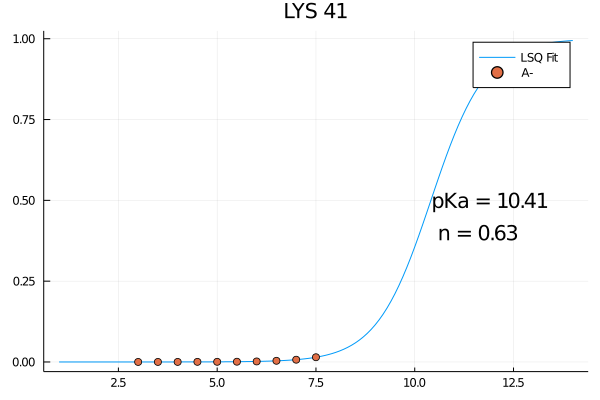

In [26]:
i = 15
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

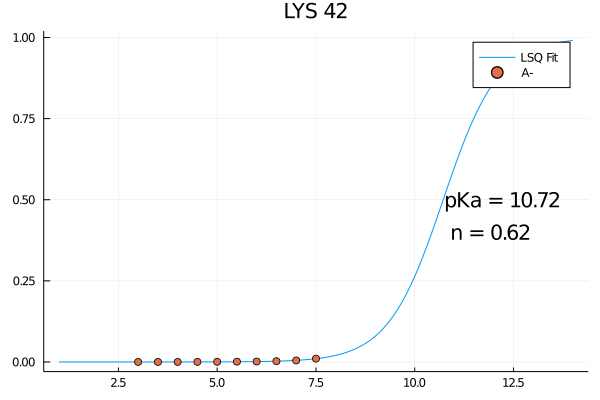

In [27]:
i = 16
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

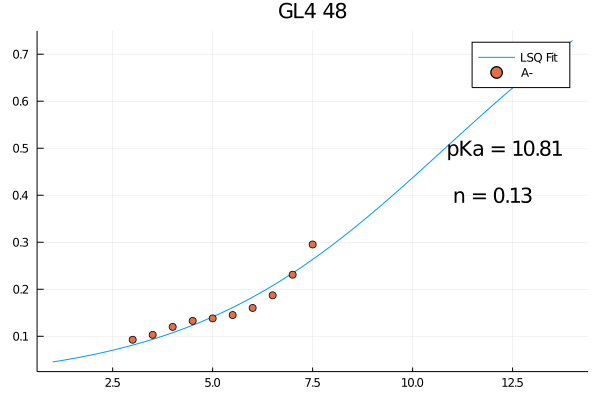

In [28]:
i = 17
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

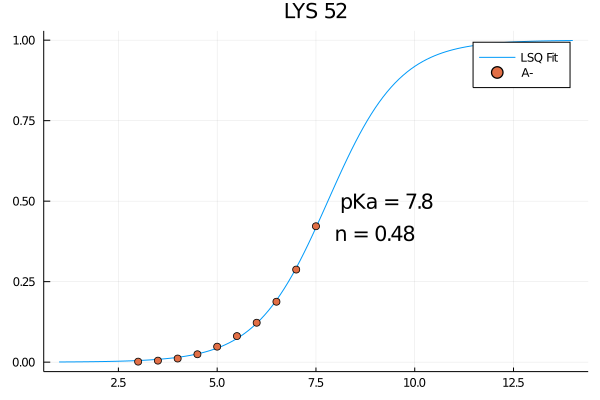

In [29]:
i = 18
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

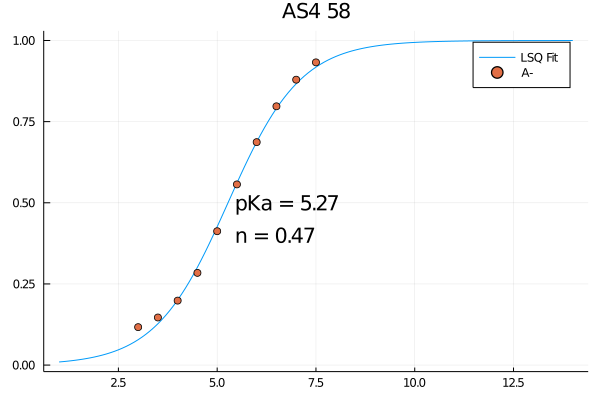

In [30]:
i = 19
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

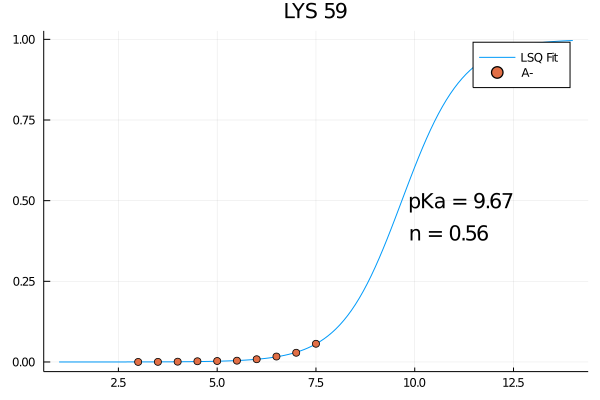

In [31]:
i = 20
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

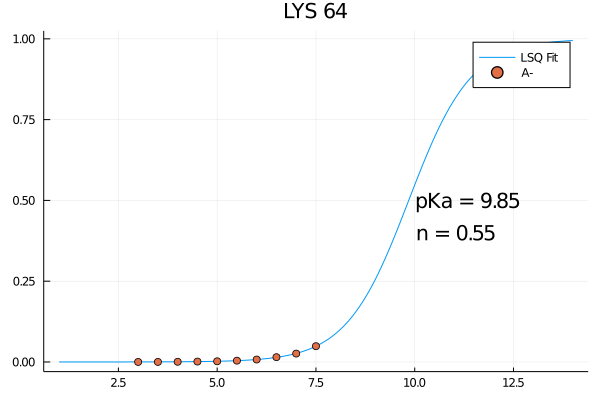

In [32]:
i = 21
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

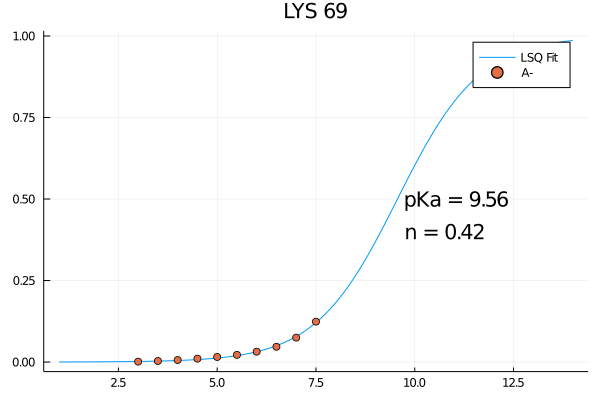

In [33]:
i = 22
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

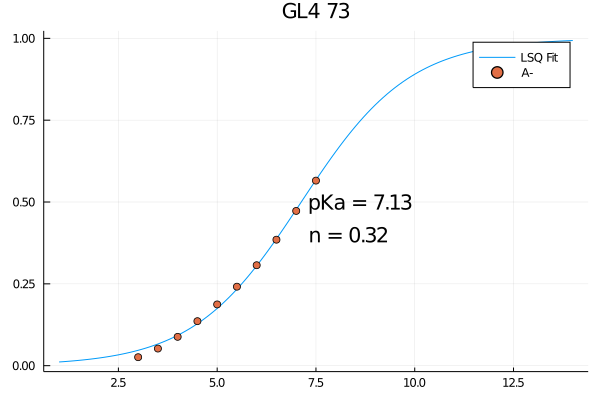

In [34]:
i = 23
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

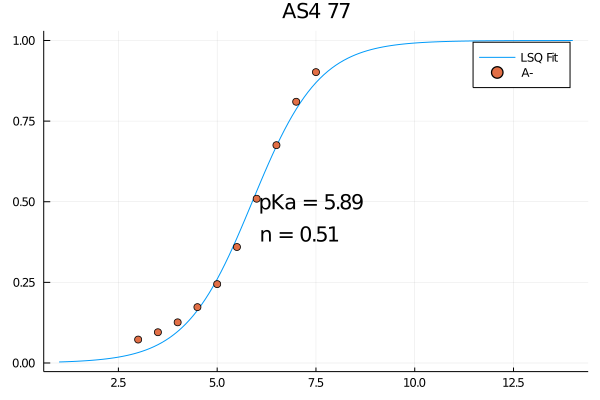

In [35]:
i = 24
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

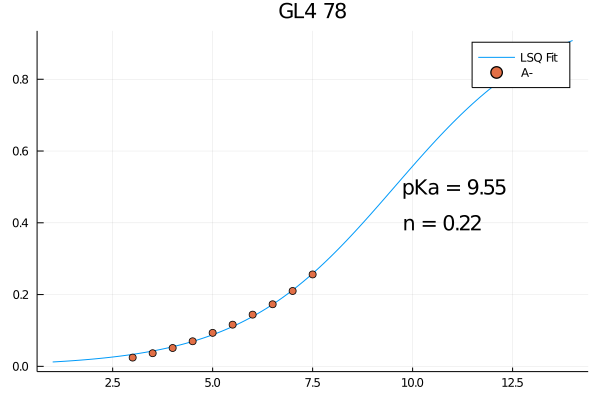

In [36]:
i = 25
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

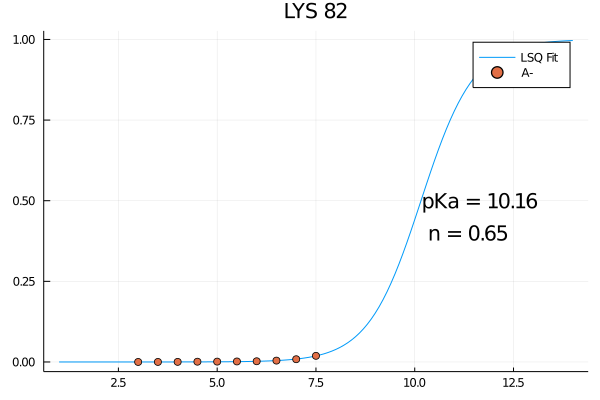

In [37]:
i = 26
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

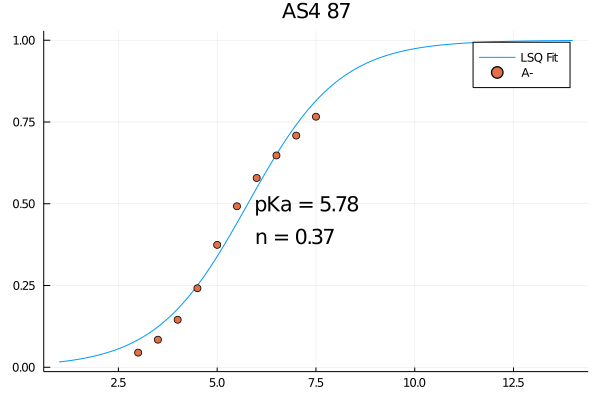

In [38]:
i = 27
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

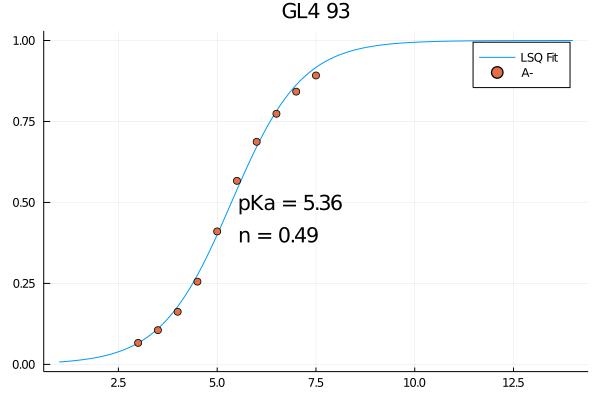

In [39]:
i = 28
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

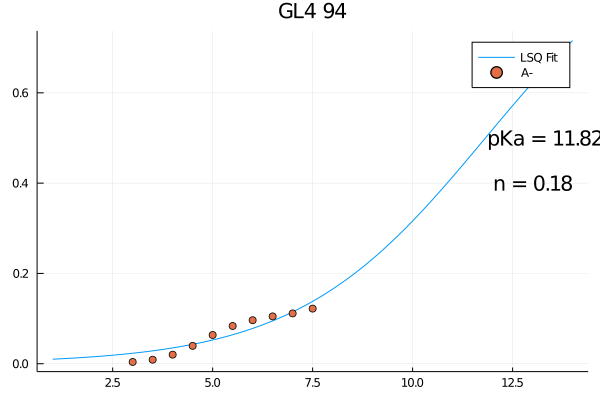

In [40]:
i = 29
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

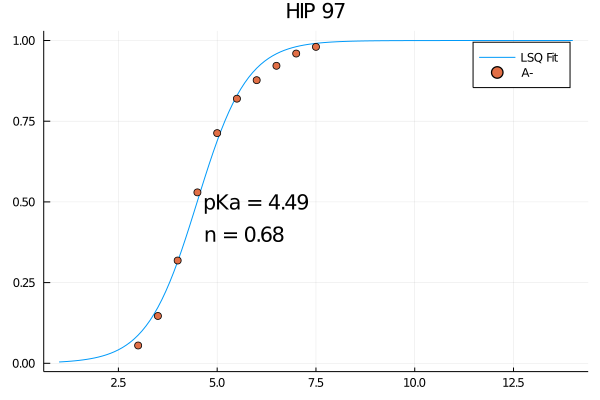

In [41]:
i = 30
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

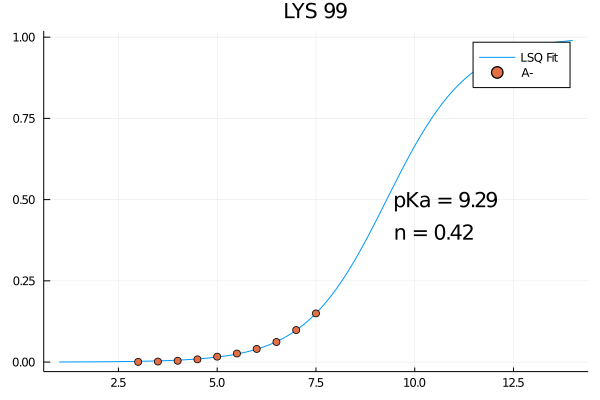

In [42]:
i = 31
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

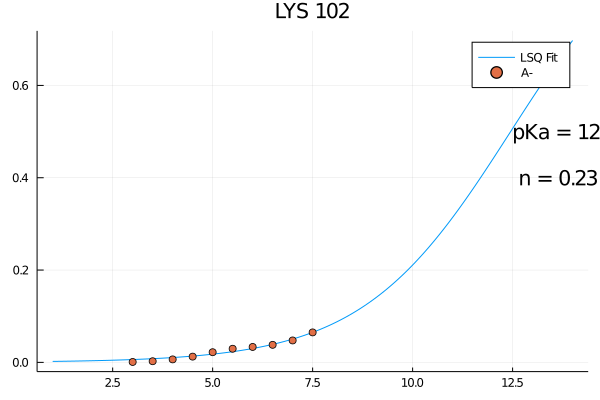

In [43]:
i = 32
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

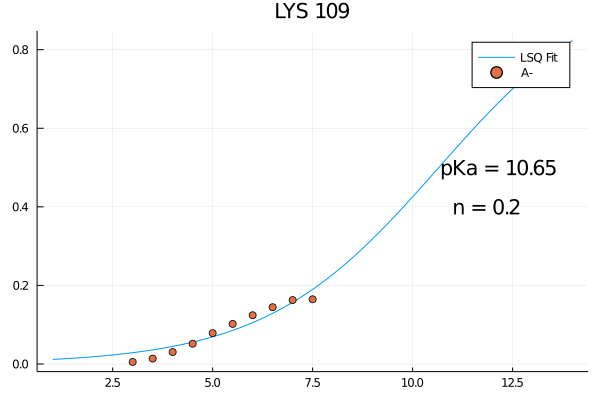

In [44]:
i = 33
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

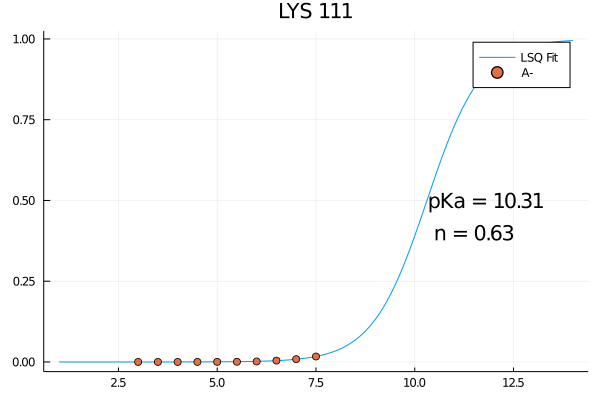

In [45]:
i = 34
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

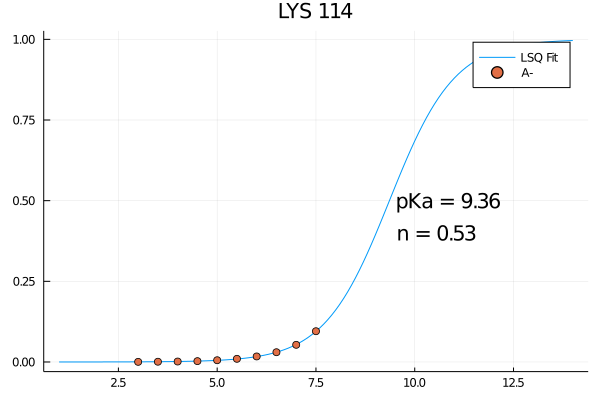

In [46]:
i = 35
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

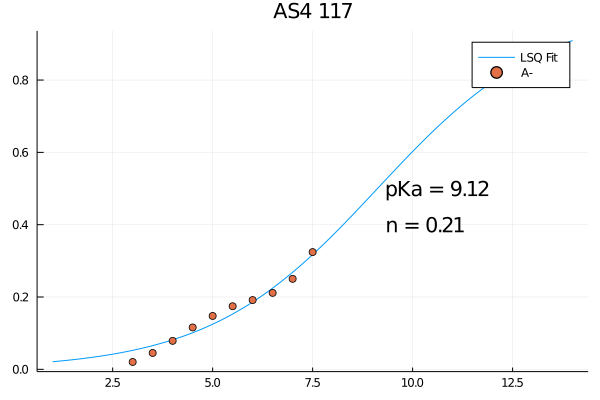

In [47]:
i = 36
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))